In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os

In [14]:
# Set seed for reproducibility
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

In [15]:
data_path = 'aces_ma - 15.csv'
df = pd.read_csv(data_path, parse_dates=['Date'])

<ipython-input-15-99e6888164ea>:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(data_path, parse_dates=['Date'])


In [16]:
df['MA'] = df['MA'].str.replace(',', '.').astype(float)

In [17]:
# Normalisasi
scaler_ma = MinMaxScaler(feature_range=(0, 1))
df['MA'] = scaler_ma.fit_transform(np.array(df['MA']).reshape(-1, 1))

In [18]:
# Pembagian data latih 90% data validasi 10%
training_size = int(len(df) * 0.9)
test_size = len(df) - training_size
train_data, test_data = df.iloc[0:training_size], df.iloc[training_size:len(df)]

In [19]:
def create_dataset(data, window_size=1):
    X, Y = [], []
    for i in range(len(data)-window_size-1):
        a = data[i:(i+window_size), 0]
        X.append(a)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)

In [20]:
window_size = 5  # Jumlah lag untuk input GRU
X_train, y_train = create_dataset(train_data['MA'].values.reshape(-1, 1), window_size)
X_test, y_test = create_dataset(test_data['MA'].values.reshape(-1, 1), window_size)

In [21]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [22]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              metrics=["mean_squared_error"],
              loss=tf.keras.losses.Huber())

In [24]:
model.fit(X_train, y_train, epochs=1000, batch_size=128,
          validation_data=(X_test, y_test),
          verbose=1)

Epoch 1/1000
28/28 [==============================] - 6s 73ms/step - loss: 0.0461 - mean_squared_error: 0.0922 - val_loss: 0.0174 - val_mean_squared_error: 0.0348
Epoch 2/1000
28/28 [==============================] - 1s 24ms/step - loss: 0.0445 - mean_squared_error: 0.0890 - val_loss: 0.0172 - val_mean_squared_error: 0.0344
Epoch 3/1000
28/28 [==============================] - 1s 23ms/step - loss: 0.0426 - mean_squared_error: 0.0851 - val_loss: 0.0170 - val_mean_squared_error: 0.0339
Epoch 4/1000
28/28 [==============================] - 1s 25ms/step - loss: 0.0399 - mean_squared_error: 0.0799 - val_loss: 0.0163 - val_mean_squared_error: 0.0326
Epoch 5/1000
28/28 [==============================] - 1s 24ms/step - loss: 0.0363 - mean_squared_error: 0.0726 - val_loss: 0.0153 - val_mean_squared_error: 0.0306
Epoch 6/1000
28/28 [==============================] - 0s 14ms/step - loss: 0.0312 - mean_squared_error: 0.0625 - val_loss: 0.0135 - val_mean_squared_error: 0.0270
Epoch 7/1000
28/28 [==

In [25]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

13/13 [==============================] - 0s 4ms/step


In [26]:
# Hasil prediksi di denormalisasi ke skala aslinya untuk '5-Day MA'
train_predict = scaler_ma.inverse_transform(train_predict)
test_predict = scaler_ma.inverse_transform(test_predict)
y_train_ma = scaler_ma.inverse_transform(y_train.reshape(-1, 1))
y_test_ma = scaler_ma.inverse_transform(y_test.reshape(-1, 1))

In [27]:
# Output metrik evaluasi untuk '5-Day MA'
train_rmse_ma = np.sqrt(mean_squared_error(y_train_ma, train_predict))
test_rmse_ma = np.sqrt(mean_squared_error(y_test_ma, test_predict))

train_mape_ma = mean_absolute_percentage_error(y_train_ma, train_predict)
test_mape_ma = mean_absolute_percentage_error(y_test_ma, test_predict)

In [28]:
print(f'Train MAPE: {train_mape_ma}, Test MAPE: {test_mape_ma}')
print(f'Train RMSE: {train_rmse_ma}, Test RMSE: {test_rmse_ma}')

Train MAPE: 0.011462541700571935, Test MAPE: 0.01111648649764025
Train RMSE: 8.21250505140738, Test RMSE: 8.232530038653676


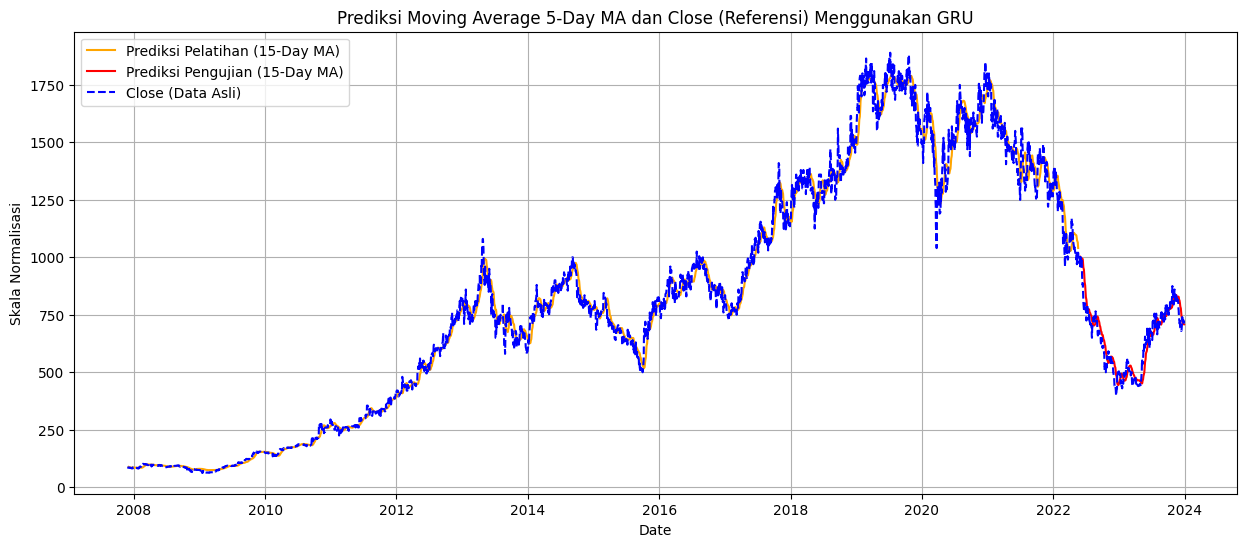

In [29]:
# Plot hasil prediksi terhadap nilai asli untuk '5-Day MA' dan 'close' sebagai referensi
plt.figure(figsize=(15, 6))
plt.plot(train_data['Date'].iloc[window_size+1:], train_predict, label='Prediksi Pelatihan (15-Day MA)', color='orange')
plt.plot(test_data['Date'].iloc[window_size+1:], test_predict, label='Prediksi Pengujian (15-Day MA)', color='red')
plt.plot(df['Date'], df['close'], label='Close (Data Asli)', color='blue', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Skala Normalisasi')
plt.title('Prediksi Moving Average 5-Day MA dan Close (Referensi) Menggunakan GRU')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
result_df = df[['Date', 'MA']].copy()
result_df['Train_Predict'] = np.nan
result_df['Test_Predict'] = np.nan

In [31]:
result_df.iloc[len(train_predict) + window_size: len(train_predict) + window_size + len(test_predict),
                 result_df.columns.get_loc('Test_Predict')] = test_predict[:, 0]
# The end index of the slice is adjusted to match the length of test_predict

In [32]:
result_df.to_csv('gru_prediction_ma15.csv', index=False)
print('Hasil prediksi untuk telah disimpan.')

Hasil prediksi untuk telah disimpan.


In [33]:
# Prediksi 270 hari ke depan
days_to_predict = 270
last_window = df['MA'][-window_size:].values.reshape(1, window_size, 1)
future_predictions = []

for i in range(days_to_predict):
    next_pred = model.predict(last_window)
    future_predictions.append(next_pred[0, 0])
    last_window = np.append(last_window[:, 1:, :], np.reshape(next_pred, (1, 1, 1)), axis=1)

future_predictions = scaler_ma.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Tambahkan prediksi masa depan ke DataFrame
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict)

# Pastikan panjang array konsisten
if len(future_dates) == len(future_predictions):
    future_df = pd.DataFrame({
        'Date': future_dates,
        'Future_Predict': future_predictions.flatten()
    })
else:
    print(f"Length mismatch: future_dates({len(future_dates)}) and future_predictions({len(future_predictions)})")


1/1 [==============================] - 0s 23ms/step


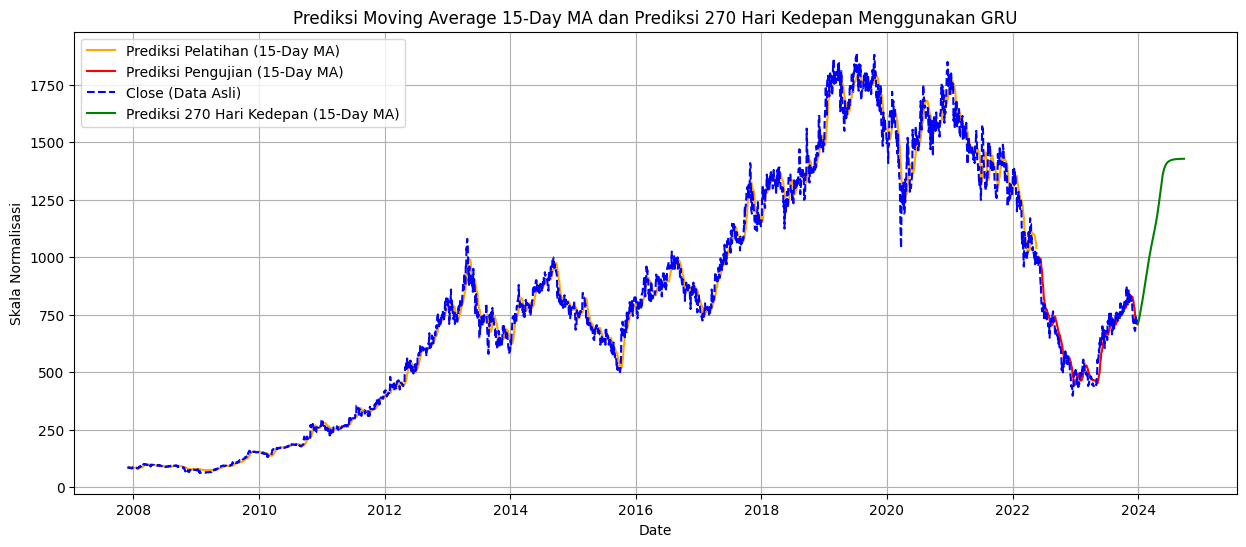

In [34]:

# Plot hasil prediksi dan prediksi masa depan
plt.figure(figsize=(15, 6))
plt.plot(train_data['Date'].iloc[window_size+1:], train_predict, label='Prediksi Pelatihan (15-Day MA)', color='orange')
plt.plot(test_data['Date'].iloc[window_size+1:], test_predict, label='Prediksi Pengujian (15-Day MA)', color='red')
plt.plot(df['Date'], df['close'], label='Close (Data Asli)', color='blue', linestyle='--')
plt.plot(future_df['Date'], future_df['Future_Predict'], label='Prediksi 270 Hari Kedepan (15-Day MA)', color='green')
plt.xlabel('Date')
plt.ylabel('Skala Normalisasi')
plt.title('Prediksi Moving Average 15-Day MA dan Prediksi 270 Hari Kedepan Menggunakan GRU')
plt.legend()
plt.grid(True)
plt.show()